In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!git clone https://github.com/prajeshkumarg/pico-llm.git
%cd pico-llm

Cloning into 'pico-llm'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 145 (delta 58), reused 96 (delta 24), pack-reused 0 (from 0)
Receiving objects: 100% (145/145), 1.83 MiB | 7.16 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/pico-llm


In [7]:
import torch
import torch.nn as nn
import numpy as np
from scipy.linalg import orthogonal_procrustes
import torch.nn.functional as F
import os
import json
import tiktoken  # GPT-2 tokenizer
import seaborn as sns
import matplotlib.pyplot as plt


In [8]:

MODEL_A_PATH = "/content/drive/MyDrive/ml_pico_models/transformer_model_2.pt"  # 2 attention layer
MODEL_B_PATH = "/content/drive/MyDrive/ml_pico_models/models/transformer_model_4_new.pt"  # 4 attention layer
MODEL_C_PATH = "/content/drive/MyDrive/ml_pico_models/transformer_model_6.pt" # 6 attention layer

In [9]:

enc = tiktoken.get_encoding("gpt2")
def create_embedding_layer(model_location,device="cpu"):
  model = torch.load(model_location,map_location=device)
  num,l = model['token_embed.weight'].shape
  embed = nn.Embedding(num,l)
  embed.weight.data.copy_(model['token_embed.weight'])
  embed.weight.requires_grad = False
  return embed

E_A = create_embedding_layer(MODEL_A_PATH).weight.detach().numpy()
E_B = create_embedding_layer(MODEL_B_PATH).weight.detach().numpy()
E_C = create_embedding_layer(MODEL_C_PATH).weight.detach().numpy()
dA = E_A.shape[1]
dB = E_B.shape[1]
dC = E_C.shape[1]
assert dA == dB and dC == dA, "Embedding dims differ → cannot align spaces!"

In [10]:
print("Performing Procrustes alignment on full vocab...")
R, _ = orthogonal_procrustes(E_A, E_B)
E_B_aligned = E_B @ R  # aligned embedding space
R,_ = orthogonal_procrustes(E_A, E_C)
E_C_aligned = E_C @ R
print("Alignment complete ✓")

Performing Procrustes alignment on full vocab...
Alignment complete ✓


In [11]:
#Load Word to vec clusters
with open("/content/pico-llm/Data/tinystories_clusters_with_word2vec_200.json", "r") as file:
    sem_clusters = json.load(file)
sem_clusters = {k:v for k,v in sem_clusters.items() if len(v)>3 and len(v)<8}


Legend:
Negative Δ → Closer in Model B
Positive Δ → Further in Model B
Correlation → Tokens drift together


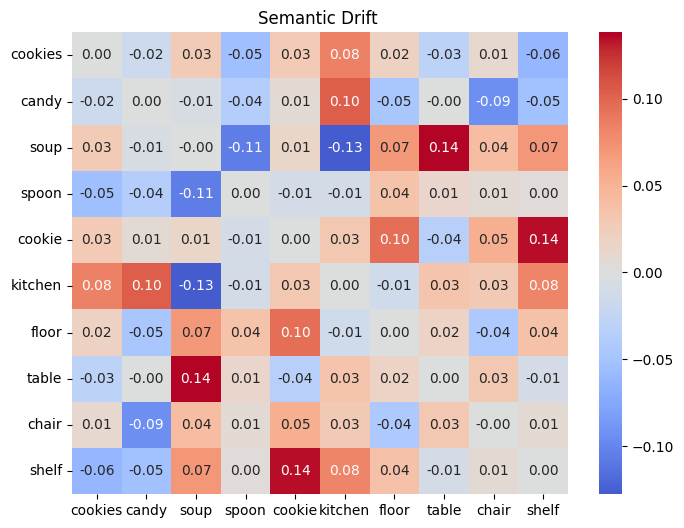

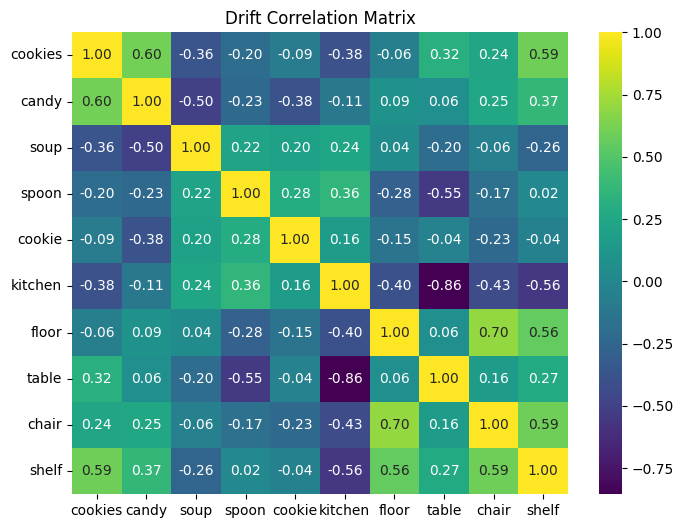

In [12]:

clusters = [
    sem_clusters['102'],
    sem_clusters["32"]
]


words = [w for group in clusters for w in group]
N = len(words)

# 🟢 Encode and average embeddings across sub-tokens
def embed(word, E):
    ids = enc.encode(word)
    vecs = [E[token_id] for token_id in ids]
    return np.mean(vecs, axis=0)  # average subtoken vectors

def cos_dist(v1, v2):
    return 1 - np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# 🟣 Drift matrix Δ = dB - dA
drift = np.zeros((N, N))
for i, w1 in enumerate(words):
    for j, w2 in enumerate(words):
        vA1, vA2 = embed(w1, E_A), embed(w2, E_A)
        vB1, vB2 = embed(w1, E_B), embed(w2, E_B)
        dA = cos_dist(vA1, vA2)
        dB = cos_dist(vB1, vB2)
        drift[i,j] = dB - dA

# Drift correlation matrix
corr = np.corrcoef(drift)

#Plottting the Drift
plt.figure(figsize=(8, 6))
sns.heatmap(drift, xticklabels=words, yticklabels=words,
            cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Semantic Drift ")
plt.savefig("drift_matrix.png")

#Plotting the Drift Correlation
plt.figure(figsize=(8, 6))
sns.heatmap(corr, xticklabels=words, yticklabels=words,
            cmap="viridis", annot=True, fmt=".2f")
plt.title("Drift Correlation Matrix")
plt.savefig("drift_corr_matrix.png")

print("\nLegend:")
print("Negative Δ → Closer in Model B")
print("Positive Δ → Further in Model B")
print("Correlation → Tokens drift together")

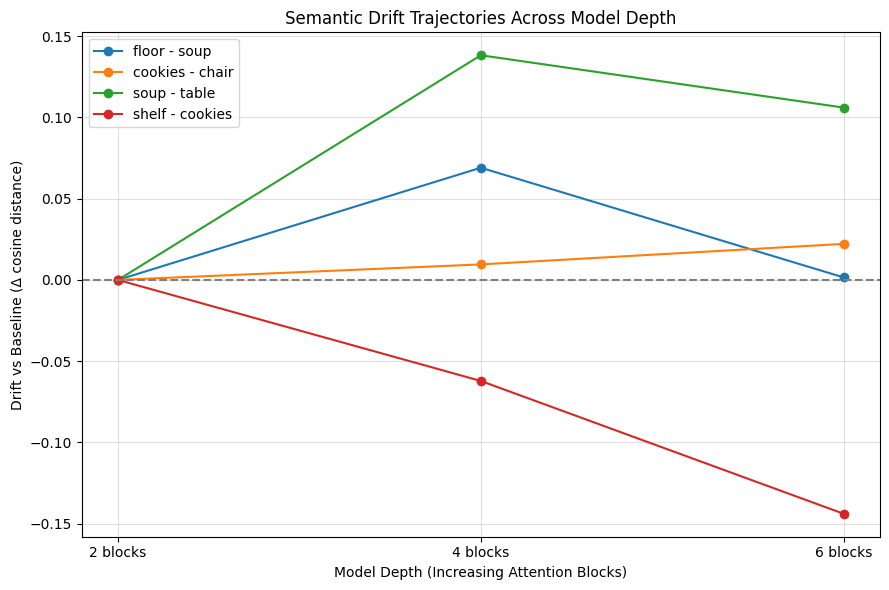

In [13]:
E_models = [E_A, E_B, E_C]  # update with your variables

model_labels = ["2 blocks", "4 blocks", "6 blocks"]  # x-axis labels

token_pairs = [
    ("floor", "soup"),
    ("cookies", "chair"),
    ("soup","table"),
    ("shelf","cookies")
]

# =========================================


num_models = len(E_models)
num_pairs = len(token_pairs)

# Drift values for plotting
drift_values = {pair: [] for pair in token_pairs}

for (w1, w2) in token_pairs:
    ids1 = enc.encode(w1)
    ids2 = enc.encode(w2)

    vecs1 = [E_models[m][ids1].mean(axis=0) for m in range(num_models)]
    vecs2 = [E_models[m][ids2].mean(axis=0) for m in range(num_models)]

    # Baseline distance (Model 0)
    d0 = cos_dist(vecs1[0], vecs2[0])

    # Drift relative to baseline for each model:
    for m in range(num_models):
        d_m = cos_dist(vecs1[m], vecs2[m])
        drift = d_m - d0
        drift_values[(w1, w2)].append(drift)


#Plot Drift for each pair
plt.figure(figsize=(9, 6))
for pair, values in drift_values.items():
    plt.plot(model_labels, values, marker="o", label=f"{pair[0]} - {pair[1]}")

plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Model Depth (Increasing Attention Blocks)")
plt.ylabel("Drift vs Baseline (Δ cosine distance)")
plt.title("Semantic Drift Trajectories Across Model Depth")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()